# Identifying Good Risk-Reward Trades In Intraday Stock Charts

## Background and Motivation

The stock market is one of the most challenging environments to predict due to its dynamic nature and significant noise, as players often create "false moves" to deceive others. However, a few individuals manage to profit from intraday movements. Successful traders distinguish themselves by taking high probability-risk trades, where the average profit per trade is a multiple of the average loss, even if they only predict the stock direction correctly 50% of the time.

Human traders face two main challenges:
1. Emotional detachment and systematic trading.
2. The ability to trade only one asset at a time.

A fully automated trading algorithm addresses the first challenge by removing emotions from trading decisions. Day traders typically use scanners configured with predefined criteria (e.g., a stock's trading volume being 1.5 times its average). The trader then examines each stock that appears on the scanner, assesses its chart and characteristics (sector, standard deviations, average volume, etc.), and exercises judgment to identify potential profit opportunities. If a promising entry point is identified after a pattern emerges, the trader executes a buy/sell order, often using a stop-loss and take-profit orders to manage risk. The stop loss can be set at a level where the trader believes the trade is no longer valid, and the take profit can be set at a level where the trader believes the stock will reach. 

Let's do an example.
Soundhound $SOUN is a highly speculative stock that has risen 20% in the day prior to today. This has attracted a lot of day traders to this stock today because of the aggressive move. It is currently 11:35 in the trading session and after peaking at 5.30 in the early trading, the stock is now down to 4.89.

![SOUN 5min chart](assets/soun_intraday.png)

The trader recognizes that this level has been touched multiple times today and looks like a good support level. Now the trader assesses the risk-reward ratio. What is a likely price the stock will go to if it bounces from the current level? 5 sounds like a good price because its a round number and it has acted as a key level in the past few days. The trader also assesses the risk. Where would he place the stop-loss in case the price doesn't bounce off the support? Looking at the session lows, the stock has not dipped below 4.85, which means that the trader can place a stop-loss at 4.84. This means that the trader is risking 5 cents to make 11 cents. This is a 2:1 risk-reward ratio. The trader decides to take the trade because the risk-reward ratio is greater than 2:1.
Next thing you know, the stock bounces off the support and reaches 5.00. The trader takes profit and makes 11 cents per share.

![SOUN 5min chart](assets/soun_intraday_2.png)

This is an example of how leveraging risk-reward rations can help traders be profitable in the stock market. Predicting a stock's price direction is very hard and would be almost impossible to do with over 50% accuracy, but taking trades where a take-profit is greater than the stop-loss can help traders be profitable even if they are right only 50% of the time.

### Project Goal

The goal of my project is to build a model that can identify good risk-reward trades in intraday stock prices. Since learning risk-reward directly from the data in a supervised manner is impossible, as there are no explicit labels for risk-reward ratios in historical data, a proxy task must be learned. In this project I will train a model to predict whether a stock will "touch" certain price levels in the future (picked heuristically both above and below the current price) given the current data. Based on the certainty of the predictions and the price levels predicted on, a risk-reward can be inferred. I will implement a trading strategy that uses the trained model, and compare it's performance to baseline strategies that rely on thresholds and heuristics.

## importing libraries and setting global settings

In [2]:
import concurrent.futures
import json
from datetime import datetime
from pathlib import Path

import numpy as np
%load_ext autoreload
%autoreload 2
import pandas as pd
from tqdm import tqdm
import yfinance as yf
from utils import get_daily_df
import json
import pandas_ta as ta
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [3]:
# Set global settings
IS_CLEAN_RUN = False
DATA_CUTOFF = datetime(2024, 7, 11)
DATA_START = datetime(2024, 1, 1)

## Data Loading And Cleaning
I collected intraday 1 minute data for stocks with over 1M average daily volume from 2024-01-01 to 2024-07-11. This accounts for 1569 total stocks, for each stock I stored the one minute bars (OHLCV) of each trading day in the date range. todo: add news data

In [4]:
if IS_CLEAN_RUN:
    # Step 1: Get all JSONL files in the data directory
    data_path = Path("/Users/iverkh/trading_bots/data/intra_day")
    jsonl_files = [file for symbol in data_path.iterdir() if symbol.is_dir() for file in symbol.iterdir() if file.suffix == ".jsonl"]
    
    # Step 2: Function to read a single JSONL file
    def read_jsonl(file):
        return pd.read_json(file, orient="records", lines=True)
    
    # Step 3: Read files in parallel and concatenate in batches
    batch_size = 100  # Adjust the batch size according to your memory capacity
    dataframes = []
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        for i in tqdm(range(0, len(jsonl_files), batch_size), desc="Reading JSONL files..."):
            batch_files = jsonl_files[i:i+batch_size]
            batch_dfs = list(executor.map(read_jsonl, batch_files))
            dataframes.append(pd.concat(batch_dfs, axis=0))
    
    # Step 4: Concatenate all batches
    df = pd.concat(dataframes, axis=0)
    df.to_parquet("data.parquet")
else:
    df = pd.read_parquet("data.parquet")
    df.set_index("datetime", inplace=True)

In [5]:
df["date"] = df.index.date
df["hour"] = df.index.hour
df["minute"] = df.index.minute
df.sort_index(inplace=True)
df.sort_values(["symbol", "datetime"], inplace=True)

In [6]:
df.info()
print(f"Number of total rows: {df.shape[0]}")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 66483995 entries, 2024-01-04 09:31:00 to 2024-07-17 16:00:00
Data columns (total 9 columns):
 #   Column  Dtype  
---  ------  -----  
 0   open    float64
 1   high    float64
 2   low     float64
 3   close   float64
 4   volume  int64  
 5   date    object 
 6   symbol  object 
 7   hour    int32  
 8   minute  int32  
dtypes: float64(4), int32(2), int64(1), object(2)
memory usage: 4.5+ GB
Number of total rows: 66483995


### Filtering Low Liquidity Stocks

The dataset consists of over 66 million rows of OHLCV bars, which is beyond the manageable scope for this project. To reduce the data size, I will calculate what I refer to as the “stock average nominal volume” for each stock. This metric is defined as the median trading volume of the stock multiplied by its average price, providing a normalized representation of the average daily dollar amount traded for that stock. By applying this calculation to the resampled daily bars dataframe, I can effectively assess the liquidity of each stock. Subsequently, I will filter the dataframe to retain only the top 100 most traded stocks in terms of nominal value (usually big and established companies), and 100 stocks with high median volume (could be highly speculative stocks).

$$
\text{Stock Average Nominal Volume}_i = \text{Median Volume}_i \times \text{Average Price}_i
$$

Where:

Median Volume (i) is the median daily trading volume for stock i.
Average Price (i) is the average daily closing price for stock i.

In [7]:
def resample_to_daily(group):
    resampled_group = group.resample('D').agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum'
    }).dropna()
    return resampled_group

# Apply the resampling function to each group
df_daily = df.groupby('symbol').apply(resample_to_daily).reset_index()
df_daily["stock_median_volume"] = df_daily.groupby("symbol")["volume"].transform("median").astype(int)
df_daily["stock_average_price"] = df_daily.groupby("symbol")["close"].transform("mean")
df_daily["stock_average_nominal_volume"] = df_daily["stock_median_volume"] * df_daily["stock_average_price"]
top_100_symbols = df_daily.groupby("symbol")['stock_average_nominal_volume'].median().nlargest(100).index
top_100_volume = df_daily.groupby("symbol")['stock_median_volume'].median().nlargest(100).index
# Filter the DataFrame to keep only the top 100 stocks by nominal volume and top 100 stocks by median volume
df_daily = df_daily[df_daily['symbol'].isin(list(top_100_symbols) + list(top_100_volume))]
df = df[df['symbol'].isin(list(top_100_symbols) + list(top_100_volume))]
print(f"Number of total one minute bars after resampling: {df.shape[0]}")
print(f"Symbols: {df_daily.symbol.unique()}")

Number of total one minute bars after resampling: 8121299
Symbols: ['AAL' 'AAPL' 'ABBV' 'ABNB' 'ABT' 'ADBE' 'AGNC' 'ALTM' 'AMAT' 'AMC' 'AMD'
 'AMZN' 'ANET' 'AVGO' 'AXP' 'BA' 'BAC' 'BLUE' 'BMY' 'BTBT' 'C' 'CAT' 'CCL'
 'CDE' 'CHPT' 'CHWY' 'CIFR' 'CLF' 'CLSK' 'CMCSA' 'COIN' 'COP' 'COST'
 'CPNG' 'CRM' 'CRWD' 'CSCO' 'CSX' 'CVNA' 'CVS' 'CVX' 'DAL' 'DELL' 'DHR'
 'DIS' 'DKNG' 'DNA' 'ENPH' 'ET' 'F' 'FCEL' 'FCX' 'FFIE' 'FUBO' 'GE' 'GERN'
 'GEV' 'GM' 'GOOG' 'GOOGL' 'GS' 'HBAN' 'HD' 'HL' 'HOLO' 'HOOD' 'HPE' 'IBM'
 'INTC' 'JBLU' 'JNJ' 'JPM' 'KEY' 'KMI' 'KO' 'KVUE' 'LAZR' 'LCID' 'LLY'
 'LUMN' 'LYFT' 'MA' 'MARA' 'MCD' 'MDLZ' 'MDT' 'META' 'MO' 'MPW' 'MRK'
 'MRO' 'MRVL' 'MS' 'MSFT' 'MSTR' 'MU' 'NCLH' 'NEE' 'NEM' 'NFLX' 'NIO'
 'NKE' 'NOVA' 'NOW' 'NVDA' 'OPEN' 'ORCL' 'OXY' 'PACB' 'PANW' 'PARA' 'PATH'
 'PCG' 'PEP' 'PFE' 'PG' 'PLTR' 'PLUG' 'PM' 'PR' 'PTON' 'PYPL' 'QCOM'
 'RIOT' 'RIVN' 'RTX' 'RUN' 'SBUX' 'SCHW' 'SIRI' 'SMCI' 'SNAP' 'SNOW'
 'SOFI' 'SOUN' 'SQ' 'SWN' 'T' 'TGT' 'TJX' 'TLRY' 'TME' 'TMO' 'TMUS' '

### Adding Fundamental Data
Traders often use fundamental data to assess a stock's "ID". Although it has less of an effect on intraday trading, it can still be useful to have this data to see the correlation between the stock's fundamentals and it's intraday price action.

In [8]:
if IS_CLEAN_RUN:
    fundamental_data = {}
    maybe_delisted = []
    for stock in tqdm(df["symbol"].unique(), desc="Fetching fundamental data..."):
        ticker = yf.Ticker(stock)
        try:
            ticker_info = ticker.info
            fundamental_data[stock] = {
                "earning_dates": [date for date in ticker.earnings_dates.index if DATA_START.date() <= date.date() < DATA_CUTOFF.date()],
                "sector": ticker_info["sector"],
                "industry": ticker_info["industry"],
                "total_shares": ticker_info["sharesOutstanding"],
                "float_shares": ticker_info["floatShares"],
            }
        except Exception as e:
            maybe_delisted.append(stock)
            continue
    for stock in fundamental_data.keys():
        fundamental_data[stock]["earning_dates"] = [date.strftime("%Y-%m-%d %H:%M:%S") for date in fundamental_data[stock]["earning_dates"]]
    with open("fundamental_data.json", "w") as f:
        json.dump(fundamental_data, f)
else:
    with open("fundamental_data.json", "r") as f:
        fundamental_data = json.load(f)
df = df[df["symbol"].isin(list(fundamental_data.keys()))]
df = df[~(df["symbol"] == "GOOGL")] # Google has 2 classes of shares, their price is identical, so we will remove one

Example for fundamental data on Apple's stock:

In [9]:
fundamental_data["AAPL"]

{'earning_dates': ['2024-05-02 16:00:00', '2024-02-01 16:00:00'],
 'sector': 'Technology',
 'industry': 'Consumer Electronics',
 'total_shares': 15204100096,
 'float_shares': 15179658339}

<Figure size 1200x800 with 0 Axes>

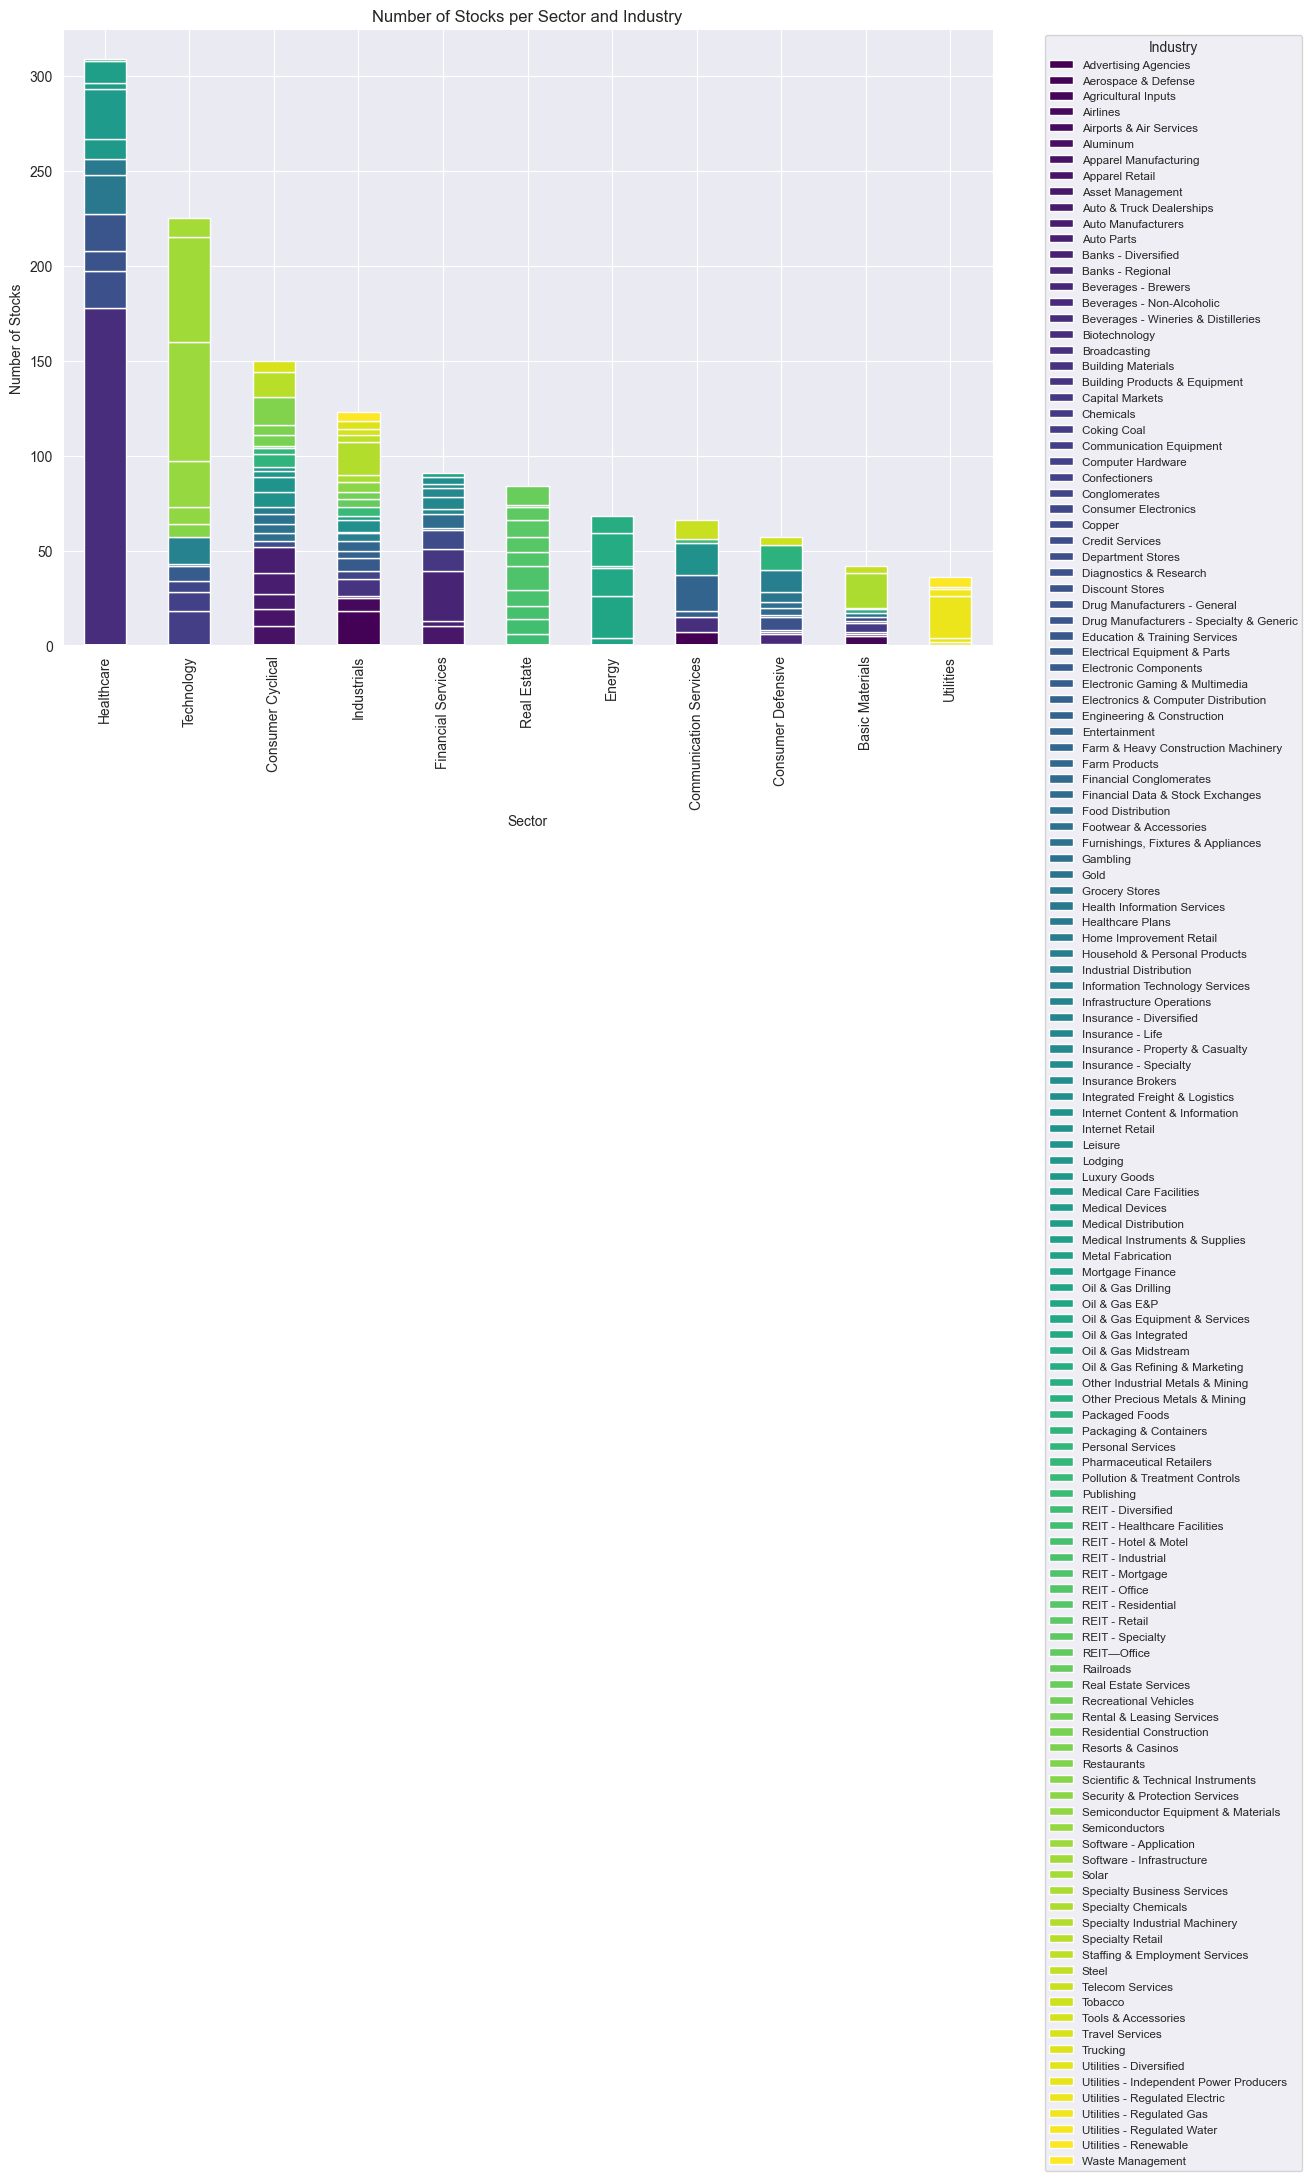

In [10]:
fundamental_df = pd.DataFrame.from_dict(fundamental_data, orient='index')
sector_industry_counts = fundamental_df.groupby(['sector', 'industry']).size().unstack(fill_value=0)
sector_totals = sector_industry_counts.sum(axis=1)
sector_industry_counts = sector_industry_counts.loc[sector_totals.sort_values(ascending=False).index]
plt.figure(figsize=(12, 8))
sector_industry_counts.plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 8))

plt.title('Number of Stocks per Sector and Industry')
plt.xlabel('Sector')
plt.ylabel('Number of Stocks')
plt.legend(title='Industry', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

Market Capitalization is a key metric that traders use to assess a stock's size. It is calculated by multiplying the stock price by the total number of shares outstanding. In the intraday dataframe context, I will use the opening price of the day as the stock price to calculate market cap. Then I divide by 1M to get the market cap in millions.
$$
\text{Market Cap} (\text{In Millions}) = (\text{Stock Price} \times \text{Total Shares}) \div 1,000,000
$$

In [11]:
df["market_cap"] = df.groupby(["symbol", "date"])["open"].transform("first") * df["symbol"].apply(lambda x: fundamental_data[x]["total_shares"]).astype(float) / 1_000_000

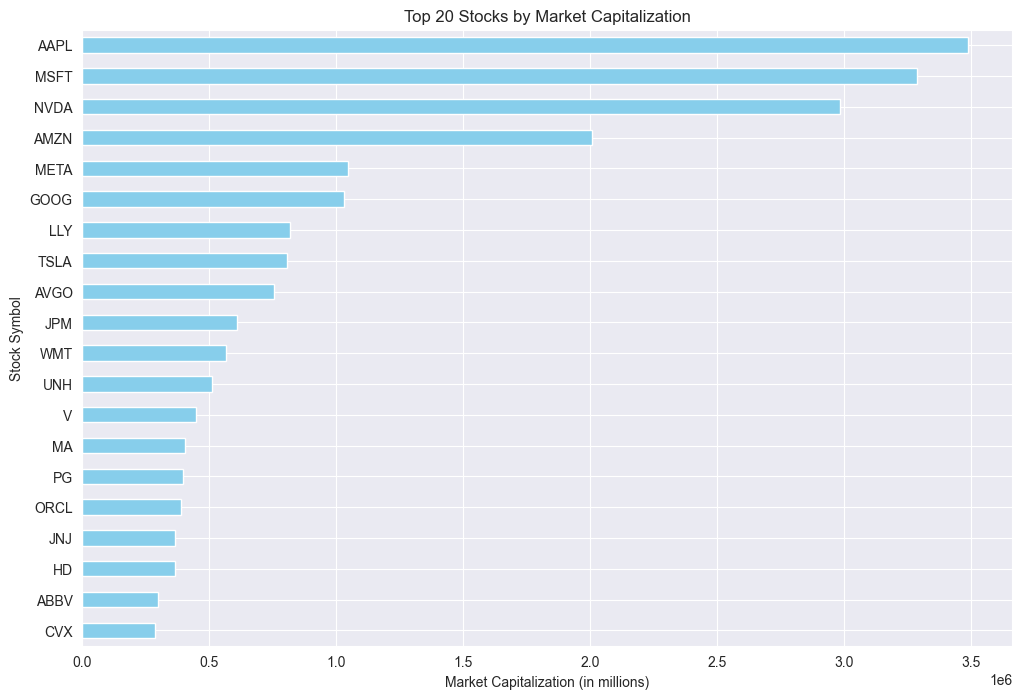

In [12]:
# Top 20 stocks by market capitalization
top_20_stocks = df.groupby("symbol")["market_cap"].last().nlargest(20)

# Step 3: Plot the top 20 stocks
plt.figure(figsize=(12, 8))
top_20_stocks.sort_values().plot(kind='barh', color='skyblue')
plt.title("Top 20 Stocks by Market Capitalization")
plt.xlabel("Market Capitalization (in millions)")
plt.ylabel("Stock Symbol")
plt.show()

In [13]:
df

,open,high,low,close,volume,date,symbol,hour,minute,market_cap
datetime,,,,,,,,,,
2024-01-04 09:31:00,13.01,13.04,12.96,12.98,328214,2024-01-04,AAL,9,31,8543.719040
2024-01-04 09:32:00,12.98,13.05,12.97,13.05,112825,2024-01-04,AAL,9,32,8543.719040
2024-01-04 09:33:00,13.05,13.06,13.03,13.03,103938,2024-01-04,AAL,9,33,8543.719040
2024-01-04 09:34:00,13.03,13.04,13.00,13.00,33754,2024-01-04,AAL,9,34,8543.719040
2024-01-04 09:35:00,12.99,13.01,12.99,12.99,16420,2024-01-04,AAL,9,35,8543.719040
...,...,...,...,...,...,...,...,...,...,...
2024-07-17 15:56:00,71.00,71.04,71.00,71.01,104208,2024-07-17,WMT,15,56,564495.634954
2024-07-17 15:57:00,71.01,71.03,71.00,71.01,115909,2024-07-17,WMT,15,57,564495.634954
2024-07-17 15:58:00,71.01,71.05,71.01,71.02,126231,2024-07-17,WMT,15,58,564495.634954


Another very important metrics in understand a stock's behaviour is its volatility. Volatility is a statistical measure of the dispersion of returns for a given security or market index. In most cases, the higher the volatility, the riskier the security. Day traders look for high volatility stocks because they can make big profits very quickly.
Historical volatility is calculated by taking the standard deviation of the stock's daily returns, divided by the opening price and then annualized.

#### Daily Volatility as a Percentage of Stock Price

The daily volatility $(\sigma_{\text{daily}})$ is calculated as:

$$
\sigma_{\text{daily}} = {\sqrt{\frac{1}{N-1} \sum_{i=1}^{N} \left( r_i - \overline{r} \right)^2}}
$$

Where:

N is the number of trading days.
r_i represents the daily return on day i.
$\overline{r}$ is the average daily return over the N days.

#### Annualized Volatility

Once the daily volatility is calculated, it is annualized using the following equation:

$$
\sigma_{\text{annual}} = \sigma_{\text{daily}} \times \sqrt{252}
$$

Where:

$\sigma_{\text{daily}}$ is the standard deviation of the stock’s daily returns.
The factor $\sqrt{252}$ annualizes the volatility, assuming there are 252 trading days in a year.

In [14]:
df_daily = df.groupby('symbol').resample('D').agg({
    'close': 'last'
}).dropna() # dropna to remove Saturdays and Sundays
# Calculate the daily log returns
df_daily['return'] = df_daily.groupby('symbol')['close'].transform(lambda x: np.log(x / x.shift(1)))
# Calculate the rolling standard deviation of the daily returns
window_size = 30
df_daily['rolling_std'] = df_daily.groupby('symbol')['return'].rolling(window=window_size, min_periods=1).std().reset_index(0, drop=True)
# Annualize the volatility
df_daily['hist_vol'] = (df_daily['rolling_std'] * np.sqrt(252))
df_daily['hist_vol'] = df_daily['hist_vol'].fillna(method='bfill')
# Merge the daily historical volatility back into the original DataFrame
df_daily["symbol"] = df_daily.index.get_level_values(0)
df_daily["datetime"] = df_daily.index.get_level_values(1)
df_daily = df_daily.reset_index(drop=True)
df_daily["date"] = df_daily["datetime"].dt.date
minute_index = df.index
df = df.merge(df_daily[['symbol', 'date', 'hist_vol']], on=['symbol', 'date'], how='left').set_index(minute_index)

#### Shares Float
The float of a stock is the number of shares available for trading of a particular stock. It is calculated by taking the total number of shares outstanding and subtracting the shares held by insiders, employees, and major shareholders. The float is an important metric for traders because it indicates the number of shares available for trading in the open market. Speculative traders love low float stocks because they can be easily manipulated by institutions with relatively small amount of money. The risk increases when trading these stocks because you might not be able to sell your position at the price you want (due to low liquidity and wild price swings).

In [15]:
df["shares_float"] = df["symbol"].apply(lambda x: fundamental_data[x]["float_shares"])

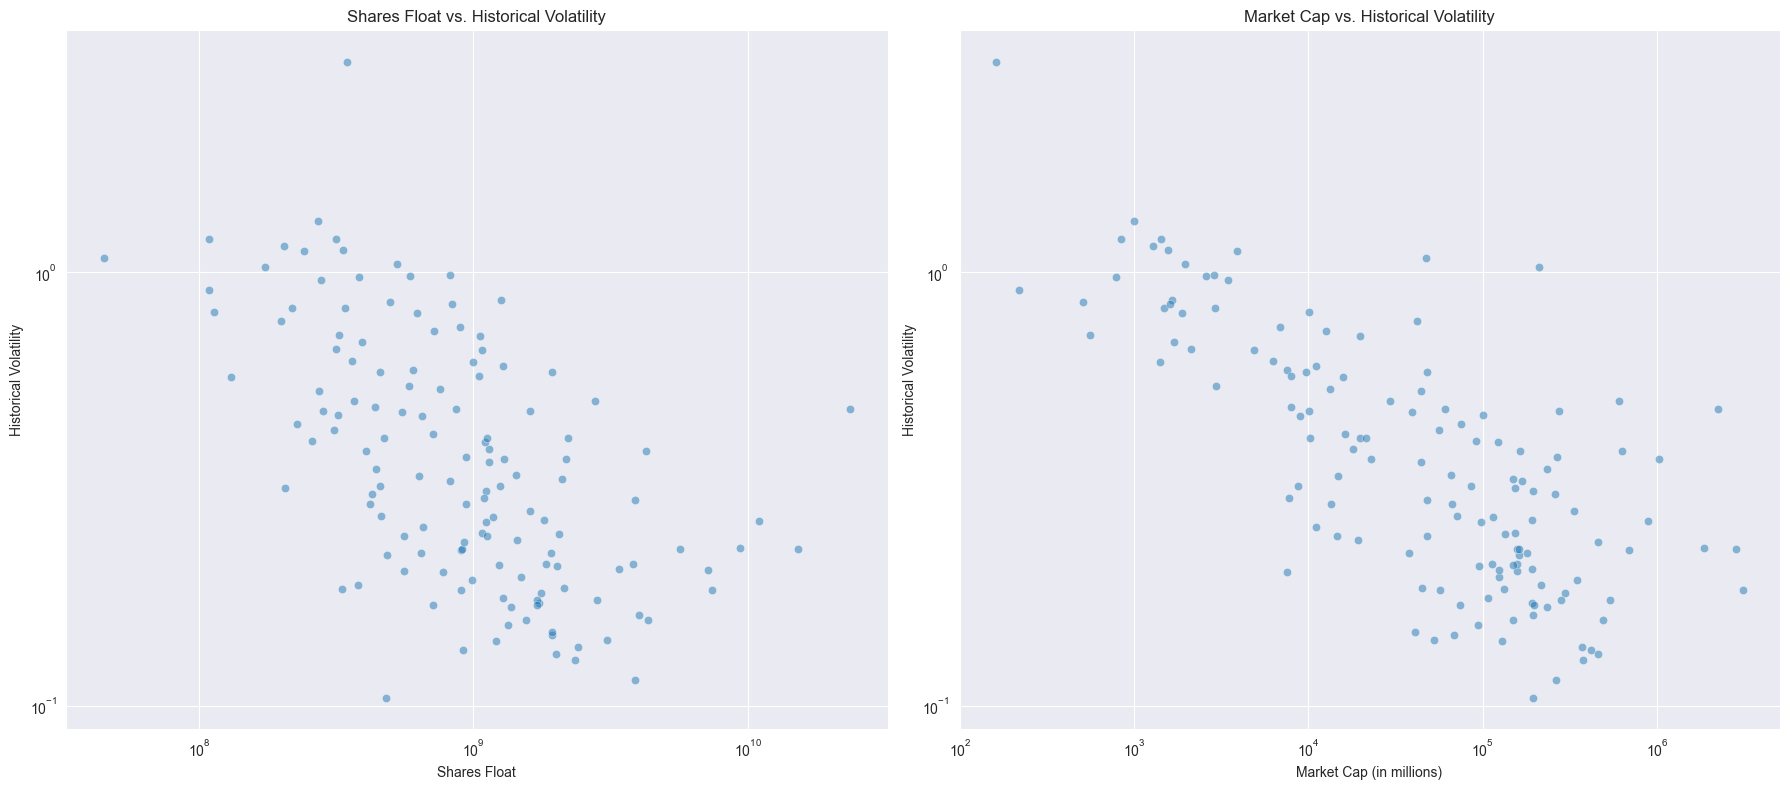

In [16]:
hist_and_float_df = df.groupby('symbol').agg({
    'hist_vol': 'mean',
    'shares_float': 'last',
    'market_cap': 'mean'
}).dropna()

# Create a 1x2 grid of plots
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot 1: Shares Float vs. Historical Volatility
sns.scatterplot(data=hist_and_float_df, x='shares_float', y='hist_vol', alpha=0.5, ax=axes[0])
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_title('Shares Float vs. Historical Volatility')
axes[0].set_xlabel('Shares Float')
axes[0].set_ylabel('Historical Volatility')

# Plot 2: Market Cap vs. Shares Float
sns.scatterplot(data=hist_and_float_df, x='market_cap', y='hist_vol', alpha=0.5, ax=axes[1])
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_title('Market Cap vs. Historical Volatility')
axes[1].set_xlabel('Market Cap (in millions)')
axes[1].set_ylabel('Historical Volatility')

# Show the plots
plt.tight_layout()
plt.show()

We can see how a stock's shares float and market cap correlate with its volatility. It is clear from the scatter plot that the more volatile stocks tend to have lower float and lower market cap. This is because the less volatile stocks are usually the big cap stocks that are heavily traded by big institutions and retail traders. The low float stocks are usually the small cap stocks that are not heavily traded by institutions and are more susceptible to manipulation.

### ATR
The Average True Range (ATR) is a technical analysis indicator that measures market volatility by calculating the average of the true range over a specified period. This indicator is used to identify stocks that usually make aggressive moves intraday. 
The ATR is calculated using the following steps:

1. True Range (TR):
The True Range is the greatest of the following three values:
$$
TR_t = \max\left( H_t - L_t, \, |H_t - C_{t-1}|, \, |L_t - C_{t-1}| \right)
$$
where:
$H_t$ = High price of the current period
$L_t$ = Low price of the current period
$C_{t-1}$ = Closing price of the previous period
2.	Average True Range (ATR):
The ATR is then calculated as the exponential moving average (EMA) of the True Range over a specified period n:
$$
ATR_t = \frac{1}{n} \sum_{i=0}^{n-1} TR_{t-i}
$$
or more commonly using the recursive formula:
$$
ATR_t = \frac{(ATR_{t-1} \times (n-1)) + TR_t}{n}
$$
where:
$ATR_t$ = Average True Range at time t
$TR_t$ = True Range at time t
n = Number of periods (e.g., 14 periods is common)

We will calculate the daily ATR for each stock in the dataset, with a period of 14 days.

In [17]:
df_daily = get_daily_df(df,{
    'close': 'last',
    'high': 'max',
    'low': 'min'
})
minute_index = df.index
df_daily["TR"] = ta.true_range(high=df_daily['high'], low=df_daily['low'], close=df_daily['close'])
df_daily["ATR"] = ta.atr(high=df_daily['high'], low=df_daily['low'], close=df_daily['close'], length=14)
df = df.merge(df_daily[['symbol', 'date', 'ATR', 'TR']], on=['symbol', 'date'], how='left')
df.set_index(minute_index, inplace=True)
df["ATR"] = df["ATR"].fillna(method='bfill')
df["TR"] = df["TR"].fillna(method='bfill')
df["ATR"] = df["ATR"] / df["close"] # Normalize ATR by the stock price
df["TR"] = df["TR"] / df["close"] # Normalize TR by the stock price

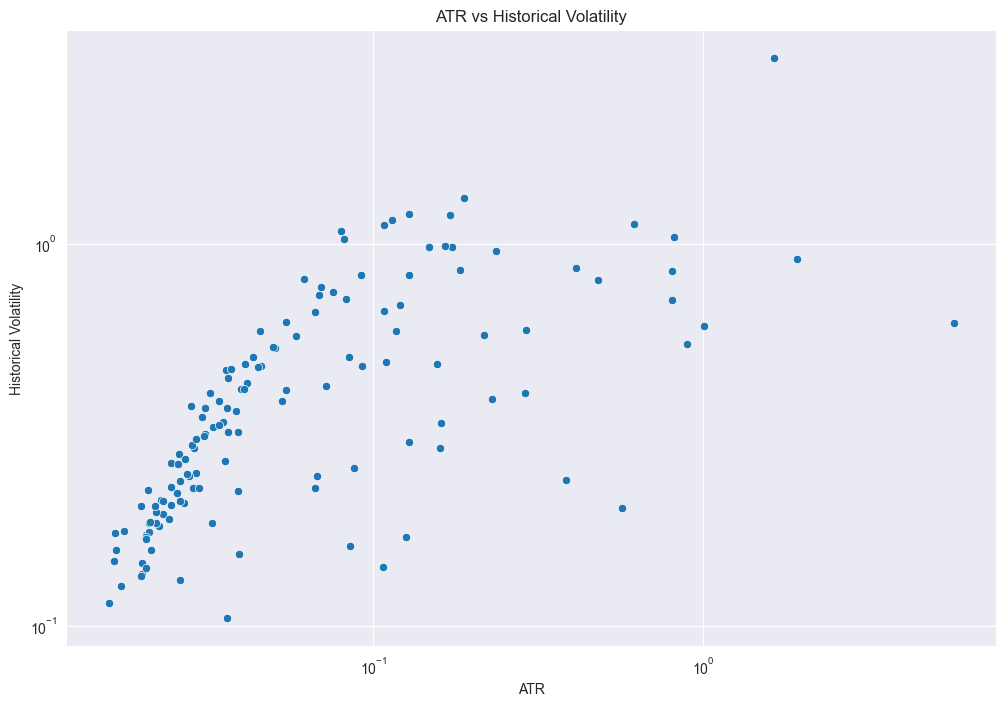

In [18]:
# plot correlation between ATR and hist_vol
data = df.groupby("symbol").agg({"hist_vol": "mean", "ATR": "mean"}).dropna()
plt.figure(figsize=(12, 8))
sns.scatterplot(data=data, x="ATR", y="hist_vol")
plt.title("ATR vs Historical Volatility")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("ATR")
plt.ylabel("Historical Volatility")
plt.show()

We can see a high correlation between ATR and historical volatility. This is expected because ATR is a measure of volatility intraday and historical volatility is a measure of dispersion of returns. The more volatile a stock is, the more likely it is to make aggressive moves intraday.

### Earnings Dates
Earnings dates are important for traders because they can cause big moves in the stock price. Companies usually release their earnings reports before the market opens or after the market closes. If the earnings are better than expected, the stock price usually goes up, and if they are worse than expected, the stock price usually goes down. Days that follow earnings releases are usually very volatile and can provide good trading opportunities.

In [19]:
from utils import get_next_trading_day

fundamental_data_df = pd.DataFrame.from_dict(fundamental_data, orient='index').explode("earning_dates").dropna()
def get_date_following_earning(date_str):
    datetime_ = datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")
    if datetime_.hour < 16:
        return datetime_.date()
    else:
        return get_next_trading_day(datetime_).date()
    
fundamental_data_df["date_after_earnings"] = fundamental_data_df["earning_dates"].apply(get_date_following_earning)
fundamental_data_df["date"] = fundamental_data_df["earning_dates"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").date())

In [20]:
df_index = df.index
df = df.merge(fundamental_data_df.reset_index()[["index", "date", "date_after_earnings"]], left_on=["symbol", "date"], right_on=["index", "date"], how="left").drop(columns=["index"]).rename(columns={"date_after_earnings": "is_earnings_day"}).fillna(False).set_index(df_index)
df["is_earnings_day"] = df["is_earnings_day"].apply(lambda date: True if date else False)

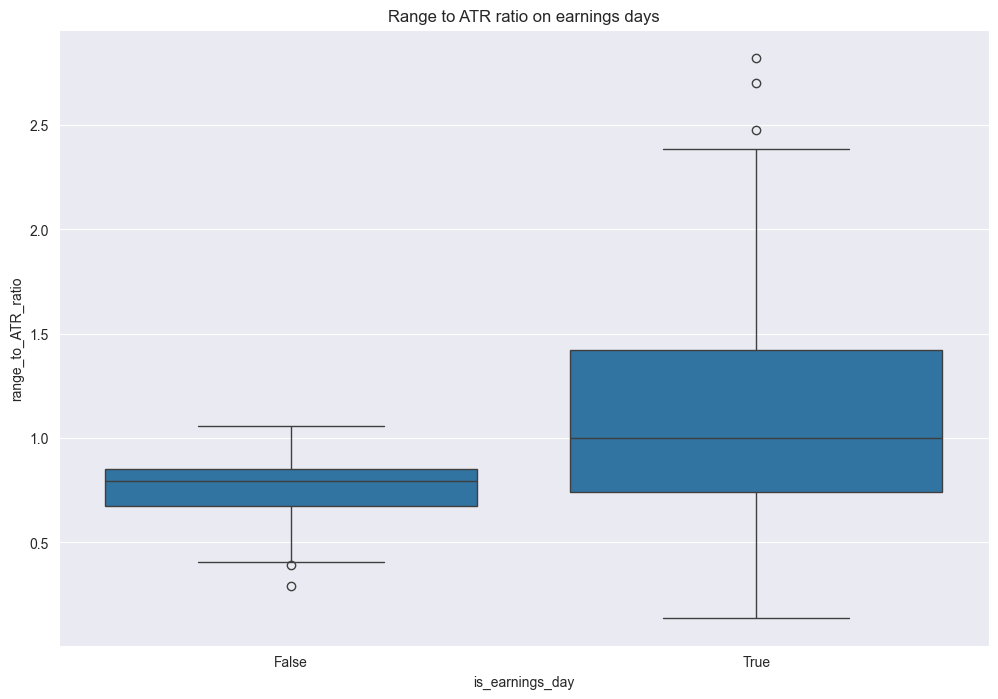

In [21]:
# range is defined as the intra-day price range of a stock
range = df.groupby(["symbol", "date"])["high"].transform("max") - df.groupby(["symbol", "date"])["low"].transform("min")
df["range_to_ATR_ratio"] = range / df["close"] / df["ATR"]
plot_agg = df.groupby(["symbol", "is_earnings_day"])["range_to_ATR_ratio"].mean().reset_index()
# plot boxplot of TR to ATR ratio on earnings days
plt.figure(figsize=(12, 8))
sns.boxplot(data=plot_agg, x="is_earnings_day", y="range_to_ATR_ratio")
plt.title("Range to ATR ratio on earnings days")
plt.show()

We can see that post-earnings days tend to be more volatile than regular trading days. This is expected because earnings releases can cause big moves in the stock price. The boxplot shows that the range to ATR ratio is higher on earnings days than on regular trading days. A stock's range does not take into account the gap between the previous day's close and the current day's open,

### Volume And Relative Volume
Volume is the number of shares traded during a given period of time. Days with larger volume play a significant role in determining key prices and trends. High volume days can indicate the presence of institutional traders, which can be a good signal for retail traders to follow. High volume days can also indicate the presence of news or other catalysts that can move the stock price.
Average daily volume is calculated as the average of the volume over the past 30 days. Rel volume at time t on day i is calculated as the sum of the volume from day start to t, divided by the average volume of the stock on day i. Stocks that have a big rel volume early in the day with a large price move, attract speculative traders.
$$
\text{Rel Volume}_t = \frac{\sum_{i=0}^{t} \text{Volume}_i}{\text{Average Volume}}
$$

In [22]:
df_daily = get_daily_df(df,{
    'volume': 'sum'
})
df_daily = df_daily[df_daily["volume"] > 0]
df_daily["average_volume"] = df_daily.groupby("symbol")["volume"].rolling(window=30, min_periods=1).mean().reset_index(0, drop=True)
df_index = df.index
df = df.merge(df_daily[["symbol", "date", "average_volume"]], on=["symbol", "date"], how="left").set_index(df_index)
df["rel_volume"] = df.groupby(["symbol", "date"])["volume"].cumsum() / df["average_volume"]

As day traders, we want to focus on stocks that have a high rel volume and pretty early during the day. This gives us the most volatility and liquidity

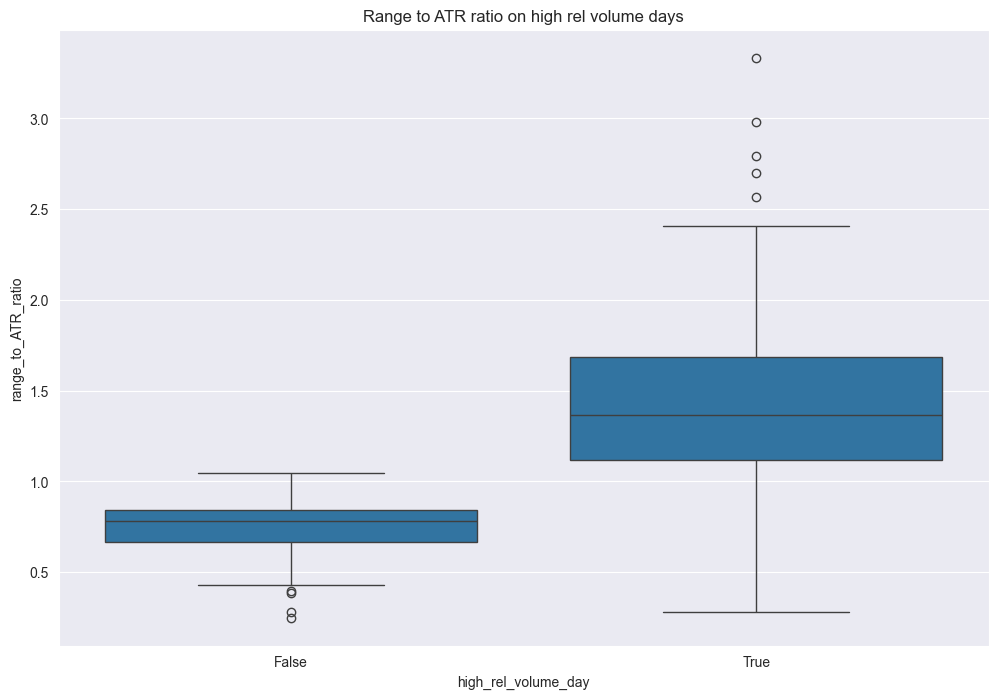

In [23]:
high_rel_vol_at_10 = 0.5 # 50% of average daily volume traded in the first half hour
df["is_high_rel_early_candle"] = (df["rel_volume"] > high_rel_vol_at_10) & (df["hour"] == 9)
df["high_rel_volume_day"] = df.groupby(["symbol", "date"])["is_high_rel_early_candle"].transform("max")
# plot boxplot of TR to ATR ratio on high rel volume days compared to regular days
plot_agg = df.groupby(["symbol", "high_rel_volume_day"])["range_to_ATR_ratio"].mean().reset_index()
plt.figure(figsize=(12, 8))
sns.boxplot(data=plot_agg, x="high_rel_volume_day", y="range_to_ATR_ratio")
plt.title("Range to ATR ratio on high rel volume days")
plt.show()

The plot shows that days with rel volume of over 0.8 in the first half hour are a lot more volatile than normal days

Some traders think that Rel Volume can also be a good gauge of move confirmations. That means, if a stock is moving up on high volume early in the day, it is more likely to continue moving up. If a stock is moving down on high volume, it is more likely to continue moving down. These trades are usually the smoothest and have the best risk-reward, because the direction is very clear, all that is needed is to "ride the trend". 

In [24]:
df["change_from_open"] = df.groupby(["symbol", "date"]).apply(lambda x: x["close"] - x["open"].iloc[0]).reset_index(drop=True).values
df["change_from_open"] = df["change_from_open"] / df["open"] # Transform to percentage

### correlation between rel volume and price action
To see if rel volume can "confirm" move directions, we can look at the average change from open of the stock between 10:00 and 12:00 and compare it to the change from open at exactly 10:00. Then we can see the correlation between the change from open and the rel volume at 10:00.

In [25]:
change_from_open_at_10 = df[(df["hour"] == 10) & (df["minute"] == 0)].groupby(["symbol", "date"])["change_from_open"].first().reset_index()
change_from_open_10_12 = df[(df["hour"] < 12) & (df["hour"] >= 10)].groupby(["symbol", "date"])["change_from_open"].mean().reset_index()
rel_volume_at_10 = df[(df["hour"] == 10) & (df["minute"] == 0)][["symbol", "rel_volume", "date", "ATR"]]

Average rel volume at 10:00: 0.5210903954664297


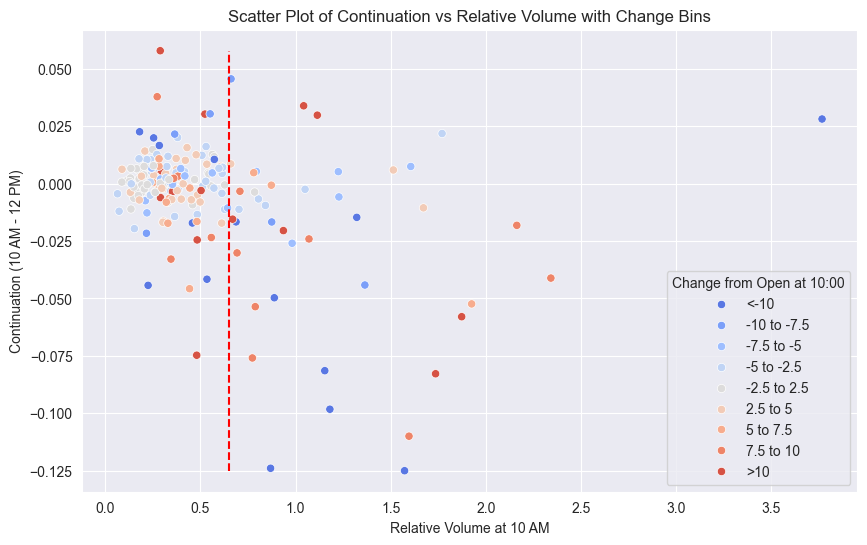

In [26]:
joined = change_from_open_at_10.merge(change_from_open_10_12, on=["symbol", "date"], suffixes=("_10", "_10_12_mean"))
joined = joined.merge(rel_volume_at_10, on=["symbol", "date"]).rename(columns={"rel_volume": "rel_volume_10"})
# we want to focus on days where the move is large in the first half hour of the day, like days where the change from open is greater than the ATR
joined = joined[joined["change_from_open_10"].abs() > joined["ATR"]]
change_bins = [-np.inf, -0.10, -0.075, -0.05, -0.025, 0.025, 0.05, 0.075, 0.10, np.inf]
change_labels = ['<-10', '-10 to -7.5', '-7.5 to -5', '-5 to -2.5', '-2.5 to 2.5', '2.5 to 5', '5 to 7.5', '7.5 to 10', '>10']
# Bin the change_from_open_10 values
joined['change_bin'] = pd.cut(joined['change_from_open_10'], bins=change_bins, labels=change_labels, include_lowest=True)
joined["is_positive_change"] = joined["change_from_open_10"] > 0
joined["continuation_move"] = joined["change_from_open_10_12_mean"] - joined["change_from_open_10"]
print(f"Average rel volume at 10:00: {joined['rel_volume_10'].mean()}")

# Scatter plot for negative days
plt.figure(figsize=(10, 6))
sns.scatterplot(x='rel_volume_10', y='continuation_move', hue='change_bin', data=joined, palette='coolwarm', legend='full')
plt.title("Scatter Plot of Continuation vs Relative Volume with Change Bins")
plt.xlabel("Relative Volume at 10 AM")
plt.ylabel("Continuation (10 AM - 12 PM)")
plt.legend(title='Change from Open at 10:00')
plt.vlines(0.65, min(joined['continuation_move']), max(joined['continuation_move']), colors='r', linestyles='dashed')
plt.show()

The scatter plot shows us that on days where the stock has move **up** in the first half-hour on very large rel volume, it is more likely to reverse in the following 2 hours. But when the stock has a large move **down** in the first half-hour on very large rel volume, it is more likely to continue moving down in the following 2 hours, this maybe explained by the fact that the stock traders are panicking and selling their positions. On the other hand, rel volume tells us nothing when it is low or average, or when the stock has not moved much in the first half-hour.

Let's see how it plays out in shorter intervals, we will take the change and rel volume at 9:45 and compare it to the period between 9:45 and 10:15 the same way we did above

In [27]:
change_from_open_at_945 = df[(df["hour"] == 9) & (df["minute"] == 45)].groupby(["symbol", "date"])["change_from_open"].first().reset_index()
change_from_open_945_10_15 = df[(df["hour"] < 10) & (df["hour"] >= 9) & (df["minute"] >= 45)].groupby(["symbol", "date"])["change_from_open"].mean().reset_index()
rel_volume_at_945 = df[(df["hour"] == 9) & (df["minute"] == 45)][["symbol", "rel_volume", "date", "ATR"]]

Average rel volume at 9:45: 0.2974440604472087


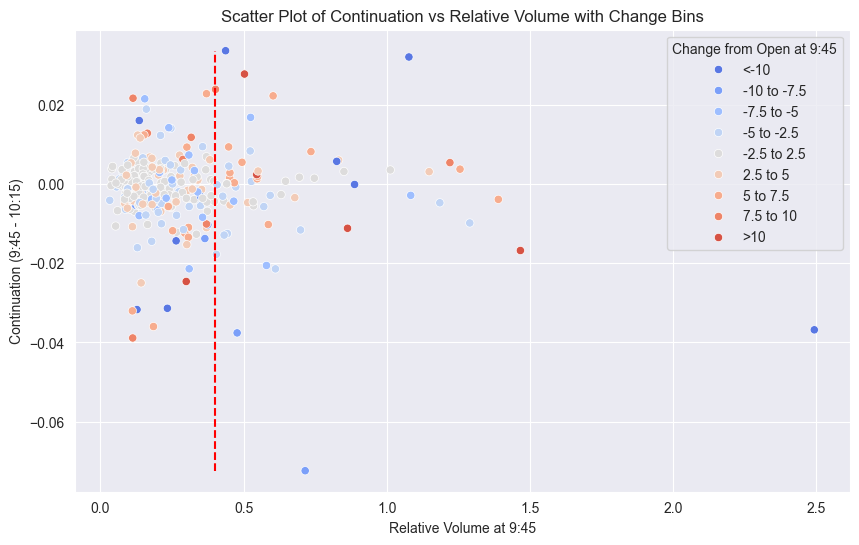

In [29]:
joined = change_from_open_at_945.merge(change_from_open_945_10_15, on=["symbol", "date"], suffixes=("_945", "_945_10_15_mean"))
joined = joined.merge(rel_volume_at_945, on=["symbol", "date"]).rename(columns={"rel_volume": "rel_volume_945"})
# we want to focus on days where the move is large in the first 15 minutes of the day, like days where the change from open is greater than 0.5ATR
joined = joined[joined["change_from_open_945"].abs() > joined["ATR"] * 0.75]
# Bin the change_from_open_10 values
joined['change_bin'] = pd.cut(joined['change_from_open_945'], bins=change_bins, labels=change_labels, include_lowest=True)
joined["is_positive_change"] = joined["change_from_open_945"] > 0
joined["continuation_move"] = joined["change_from_open_945_10_15_mean"] - joined["change_from_open_945"]
print(f"Average rel volume at 9:45: {joined['rel_volume_945'].mean()}")
# Scatter plot for negative days
plt.figure(figsize=(10, 6))
sns.scatterplot(x='rel_volume_945', y='continuation_move', hue='change_bin', data=joined, palette='coolwarm', legend='full')
plt.title("Scatter Plot of Continuation vs Relative Volume with Change Bins")
plt.xlabel("Relative Volume at 9:45")
plt.ylabel("Continuation (9:45 - 10:15)")
plt.legend(title='Change from Open at 9:45')
plt.vlines(0.4, min(joined['continuation_move']), max(joined['continuation_move']), colors='r', linestyles='dashed')
plt.show()


At smaller time intervals we can see that strong up moves on high relative volume in the first 15 minutes of the day are likely to be sustained / continue higher through the next 30 minutes.

## Gaps
Gaps are a common occurrence in the stock market. A gap is a break between prices on a chart that occurs when the price of a stock makes a sharp move up or down with no trading occurring in between. Gaps can be caused by a number of factors, such as news, earnings reports, or market sentiment. Traders often look for gaps as they can provide good trading opportunities. There are four types of gaps:
1. Common gaps: These gaps are usually small and are often filled quickly.
2. Breakaway gaps: These gaps occur when the price breaks out of a trading range.
3. Runaway gaps: These gaps occur during a strong trend and indicate that the trend is likely to continue.
4. Exhaustion gaps: These gaps occur at the end of a trend and signal that the trend is likely to reverse.

Gaps analysis takes into account daily gaps which are the difference between the previous day's close and the current day's open. Gaps are very common after earnings, as the investor's reaction to the earnings report moves the stock in the pre-market or after-market. Let's analyze the correlation between gap fills on the daily chart and the volume of the stock in the day of the gap.


In [53]:
daily_df = df.groupby(["symbol", "date"]).agg({
    "close": "last",
    "open": "first",
    "high": "max",
    "low": "min",
    "volume": "sum",
    "average_volume": "first"
}).reset_index() 
daily_df["previous_close"] = daily_df.groupby("symbol")["close"].shift(1).fillna(daily_df["close"])
daily_df["gap"] = daily_df["open"] - daily_df["previous_close"]
gaps = daily_df[daily_df["gap"].abs() > daily_df["close"] * 0.01] # Filter out small gaps
gaps["is_positive"] = gaps["gap"] > 0
gaps["has_gap_filled_intraday"] = gaps.apply(lambda row: row["low"] <= row["previous_close"] if row["is_positive"] else row["high"] >= row["previous_close"], axis=1)
gaps["gap_size"] = gaps["gap"] / gaps["close"]
gaps["volume_to_average_volume"] = gaps["volume"] / gaps["average_volume"]
gaps["close_percentile_of_range"] = (gaps["close"] - gaps["low"]) / (gaps["high"] - gaps["low"])

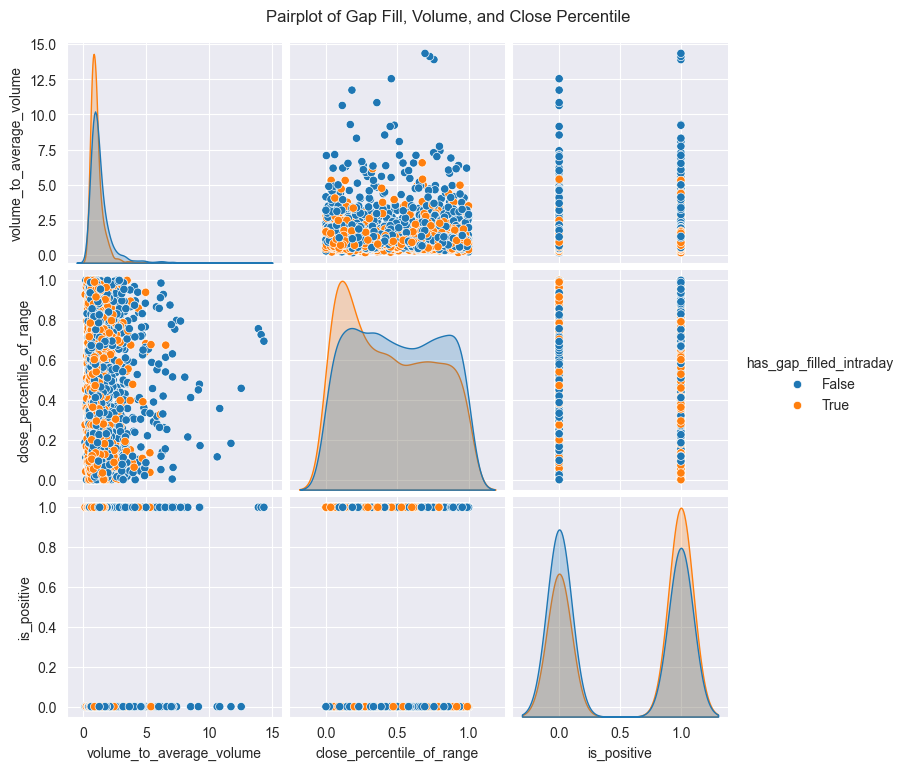

In [54]:
# Selecting the relevant columns for correlation
correlation_data = gaps[["has_gap_filled_intraday", "volume_to_average_volume", "close_percentile_of_range", "is_positive"]]
sns.pairplot(correlation_data, hue="has_gap_filled_intraday")
plt.suptitle("Pairplot of Gap Fill, Volume, and Close Percentile", y=1.02)
plt.show()

The relationship between close_percentile_of_range and volume_to_average_volume. is very interesting. It shows us that if the gap is not filled intraday, the stock is likely to close in the upper bound of the range, especially on high volume days. This means that the stock can either continue in one direction after the gap and close around the highs (or lows for down days), or it can retest the gap and that bounce back in the original direction.
The bottom right graph is also informative. It shows that negative gaps are less likely to fill than positive gaps, which makes shorting negative gaps is likelier to succeed than going long on positive gaps.